In [ ]:
! pip install -q kaggle

In [ ]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.0 MB/s eta 0:00:00


In [ ]:
!pip install datasets evaluate transformers[sentencepiece] -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.2 MB/s eta 0:00:00


In [ ]:
!pip install accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 2.6 MB/s eta 0:00:00


## Load dataset



In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ngngnhth","key":"5290e92e6b638bfcfb9423d2c730ab9d"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis
! mkdir train
! unzip twitter-entity-sentiment-analysis.zip -d train

100% 1.99M/1.99M [00:01<00:00, 2.22MB/s]
100% 1.99M/1.99M [00:01<00:00, 1.94MB/s]
Archive:  twitter-entity-sentiment-analysis.zip
  inflating: train/twitter_training.csv  
  inflating: train/twitter_validation.csv  


## Preprocess text

In [ ]:
import pandas as pd
df = pd.read_csv('/content/train/twitter_training.csv', names=['tweet_id', 'entity', 'labels', 'content'])
df = df.drop_duplicates(subset='tweet_id')
df = df.loc[:, ['content', 'labels']]
df = df[df['labels'] != 'Irrelevant']

In [ ]:
import re
def preprocess_text(sentence):
  sentence = re.sub(r'#(\w+)', '', sentence)
  sentence = re.sub(r'@(\w+)', '', sentence)
  sentence = re.sub(r'[^\w\s]', '', sentence)

  return sentence

In [ ]:
df['cleaned_content'] = df.content.apply(preprocess_text)

## EDA

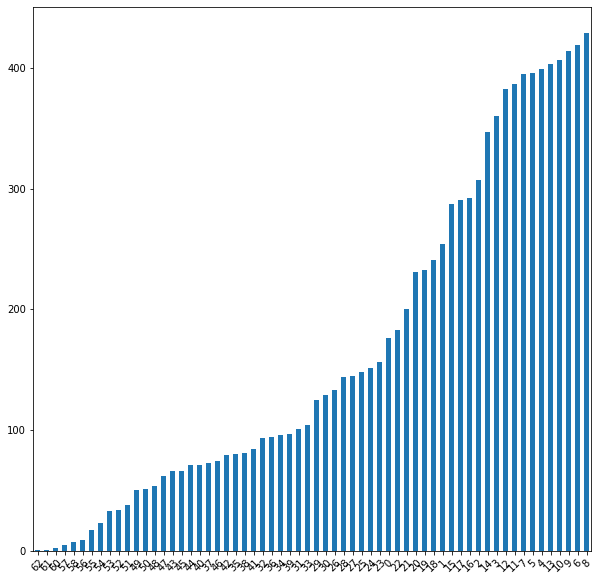

In [ ]:
import matplotlib.pyplot as plt

df['text_length'] = df.cleaned_content.apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 10))
df.text_length.value_counts(ascending=True).plot(kind='bar', rot=45)

In [ ]:
df.cleaned_content.sample(5).values

array(['This would be entertaining',
       'I will be streaming over on at 530 CST I will be playing  ',
       '  cant complete missions because your game keeps doing this after I played something I dont want plunder for 20 minutes twice   pictwittercomzuYtjIVnOD',
       'Massive respect and thank you to the LEGEND Israel Adesanya UFC Middle Weight Champion of the World for shouting out our World of Warcraft Classic Guild  Mayhem on Yojamba OCE US Horde    httpstcotn2Ae7A0hC',
       '279532 Garrosh Hearthstone WOW Hellscream Game PRINT GLOSSY POSTER US Exciting 716  '],
      dtype=object)

In [ ]:
df.labels.value_counts()

Negative    3757
Positive    3472
Neutral     3053
Name: labels, dtype: int64

## Tokenize

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F

In [ ]:
model_checkpoint = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
sample_txt = ['So the   servers were down for more than 8 hours on Friday and yall didnt adjust any rewards cmon',
       '5 years old and its in worse condition than Black Ice Y1S1 was Cant get operation health again Ops might develop MS and get shackles instead The only game where the ground or the sky becomes the back of your head Amiright ',
       'You really gotta spend like 200 on  just to enjoy ya myplayer Thats trash b',
       'LOOK WHAT I MADE with my world of warcraft cook book   they were sooo good hoping to make more ahead   ',
       'Microsoft Dynamics 365 CE  CDS Devs Remember  ExecuteMultipleRequest within Plugins is bad  It can create TimeOuts and is not needed to ensure items are contained in a transaction   ']

encoding = tokenizer(sample_txt, padding='longest', return_tensors='pt', return_token_type_ids=False)

In [ ]:
id2label = {id:label for id, label in enumerate(df.labels.unique())}
label2id = {label:id for id, label in id2label.items()}

id2label, label2id

({0: 'Positive', 1: 'Neutral', 2: 'Negative'},
 {'Positive': 0, 'Neutral': 1, 'Negative': 2})

In [ ]:
class TwitterSentDataset(Dataset):
  def __init__(self, contents, labels, tokenizer):
    self.contents = contents
    self.labels = labels
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.contents)

  def __getitem__(self, index):
    tweet_content = str(self.contents[index])
    tweet_label = label2id[self.labels[index]]

    encoding = self.tokenizer(tweet_content, return_token_type_ids=False)

    return {
        'input_ids': encoding['input_ids'],
        'attention_mask': encoding['attention_mask'],
        'labels': tweet_label
    }

## Model

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained(model_checkpoint)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids, attention_mask)
    outputs = self.drop(outputs.pooler_output)
    return self.out(outputs)

## Train_step

In [ ]:
def train_step(model, loss_fn,
               optimizer, scheduler,
               train_dataloader,
               device):
  model.train()
  total_loss, total_acc = 0.0, 0.0

  for samples in train_dataloader:
    # input_ids = samples['input_ids'].to(device)
    # attention_mask = samples['attention_mask'].to(device)
    # labels = samples['labels'].to(device)

    input_ids = samples['input_ids']
    attention_mask = samples['attention_mask']
    labels = samples['labels']

    outputs = model(input_ids, attention_mask)
    loss = loss_fn(outputs, labels)
    preds = torch.argmax(torch.softmax(outputs, dim=-1), dim=-1)

    total_loss += loss.item()
    total_acc += (preds == labels).sum().item() / len(labels)

    optimizer.zero_grad()
    accelerator.backward(loss)
    # loss.backward()
    optimizer.step()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
  scheduler.step()

  return total_loss / len(train_dataloader), total_acc / len(train_dataloader)

## Eval_step

In [ ]:
def eval_step(model, loss_fn,
               eval_dataloader,
               device):
  model.eval()
  total_loss, total_acc = 0.0, 0.0

  with torch.inference_mode():
    for samples in eval_dataloader:
      # input_ids = samples['input_ids'].to(device)
      # attention_mask = samples['attention_mask'].to(device)
      # labels = samples['labels'].to(device)

      input_ids = samples['input_ids']
      attention_mask = samples['attention_mask']
      labels = samples['labels']

      outputs = model(input_ids, attention_mask)
      loss = loss_fn(outputs, labels)
      preds = torch.argmax(torch.softmax(outputs, dim=-1), dim=-1)

      total_loss += loss.item()
      total_acc += (preds == labels).sum().item() / len(labels)

  return total_loss / len(eval_dataloader), total_acc / len(eval_dataloader)

In [ ]:
import wandb
wandb.login()

wandb.init(project="pytorch-demo", name='SentimentAnalysis_BERT', config={'epochs':3,
                                                                          'classes':len(id2label),
                                                                          'batch_size':16,
                                                                          'learning_rate':3e-5,
                                                                          'dataset':"tweet_sentiment",
                                                                          'architecture':"BERT"})

config = wandb.config

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.15, random_state=42)

In [ ]:
train_dataset = TwitterSentDataset(df_train['content'].to_numpy(), 
                                   df_train['labels'].to_numpy(), 
                                   tokenizer)

eval_dataset = TwitterSentDataset(df_val['content'].to_numpy(), 
                                   df_val['labels'].to_numpy(), 
                                   tokenizer)

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(train_dataset, 
                              batch_size=config.batch_size,
                              shuffle=True,
                              collate_fn=data_collator)
eval_dataloader = DataLoader(eval_dataset, 
                              batch_size=config.batch_size,
                              collate_fn=data_collator)

In [ ]:
for batch in train_dataloader:
  break

{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([16, 95]),
 'attention_mask': torch.Size([16, 95]),
 'labels': torch.Size([16])}

In [ ]:
from tqdm.auto import tqdm
from collections import defaultdict
from accelerate import Accelerator

model = SentimentClassifier(config.classes)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
total_steps = len(train_dataloader)*config.epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

accelerator = Accelerator()

train_dataloader, eval_dataloader, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, model, optimizer
)

best_model = model.state_dict()
best_eval_acc = 0
history = defaultdict(list)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
for epoch in tqdm(range(config.epochs)):
  train_loss, train_acc = train_step(model, loss_fn, 
                                     optimizer, scheduler,
                                     train_dataloader,
                                     device)
  
  eval_loss, eval_acc = eval_step(model, loss_fn, 
                                     eval_dataloader,
                                     device)
  
  if best_eval_acc < eval_acc:
    best_model = model.state_dict() 
    best_eval_acc = eval_acc

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(eval_acc)
  history['val_loss'].append(eval_loss)

  wandb.log({"train_loss": train_loss, "train_acc": train_acc, 'eval_loss': eval_loss, 'eval_acc': eval_acc})

  print(f'Epoch {epoch+1:^2} / {config.epochs} | Train loss: {train_loss:.4f} | Train_acc: {train_acc:.2f} | Eval loss: {eval_loss:.4f} | Eval acc: {eval_acc:.2f}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1  / 3 | Train loss: 0.8008 | Train_acc: 0.66 | Eval loss: 0.7279 | Eval acc: 0.69
Epoch 2  / 3 | Train loss: 0.5700 | Train_acc: 0.78 | Eval loss: 0.8003 | Eval acc: 0.68
Epoch 3  / 3 | Train loss: 0.3405 | Train_acc: 0.88 | Eval loss: 0.9541 | Eval acc: 0.70


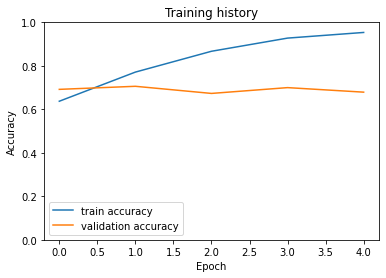

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluation

In [ ]:
test_dataset = TwitterSentDataset(df_test['content'].to_numpy(), 
                                   df_test['labels'].to_numpy(), 
                                   tokenizer)

test_dataloader = DataLoader(test_dataset, 
                              batch_size=config['batch_size'],
                              collate_fn=data_collator)

In [ ]:
accelerator = Accelerator()

test_dataloader, model, optimizer = accelerator.prepare(
    test_dataloader, model, optimizer
)

test_result = eval_step(model, loss_fn, test_dataloader, device)
test_result

wandb.log({"test_accuracy": test_result[1]})

In [ ]:
# Save the model in the exchangeable ONNX format
x_in = torch.tensor([101, 3505, 102], device=device)
x_attn = torch.tensor([1, 1, 1], device=device)

torch.onnx.export(model, args=(x_in.unsqueeze(0), x_attn.unsqueeze(0)), f="model.onnx")

wandb.save("model.onnx")

wandb.finish()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_dataloader
)
class_names = list(label2id.keys())
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Positive       0.74      0.74      0.74       150
     Neutral       0.69      0.63      0.66       133
    Negative       0.78      0.83      0.80       180

    accuracy                           0.74       463
   macro avg       0.74      0.73      0.73       463
weighted avg       0.74      0.74      0.74       463



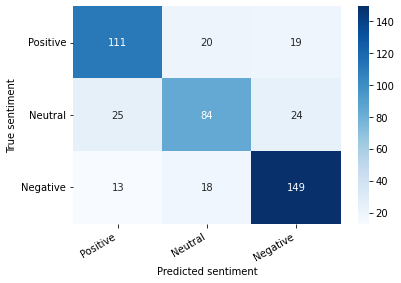

In [ ]:
import seaborn as sns

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

---